# Blockchain Main Classes

In [1]:
import hashlib
import pickle
import copy
import timeit
import matplotlib.pyplot as plt

## Completar la clase RSA_KEY

In [2]:
class rsa_key:            
    def __init__(self,bits_modulo=2048,e=2**16+1):
        def generatePQ(NdeBits):
            r1=randint(0,2^(NdeBits/2));
            r2=randint(0,2^(NdeBits/2));
            p=next_probable_prime(r1);
            while gcd(e,p-1)!=1:
                print( ".");
                p=next_probable_prime(p+2);

            q=next_probable_prime(r2);
            while gcd(e,q-1)!=1:
                print( "+");
                q=next_probable_prime(q+2);
            return p, q

        
        self.primeP, self.primeQ = generatePQ(bits_modulo)
        self.publicExponent = e
        self.privateExponent = mod(e^-1, (self.primeP-1)*(self.primeQ-1))
        self.modulus = self.primeP * self.primeQ
        self.privateExponentModulusPhiP = mod(self.privateExponent, self.primeP-1)
        self.privateExponentModulusPhiQ = mod(self.privateExponent, self.primeQ-1)
        self.inverseQModulusP = mod(self.primeQ^-1, self.primeP)
        
    def sign(self,message):
        cp=mod(message,self.primeP); #Necesario para que trabaje en Zp, si no tarda mucho
        cq=mod(message,self.primeQ); #Necesario para que trabaje en Zq, si no tarda mucho
        mp=Integer(mod(cp ^ self.privateExponentModulusPhiP,self.primeP));
        mq=Integer(mod(cq ^ self.privateExponentModulusPhiQ,self.primeQ));
        h=mod((mp-mq)*Integer(self.inverseQModulusP),self.modulus);
        m_tcr=mod((mq+self.primeQ*h),self.modulus);
        return m_tcr
    
    def sign_slow(self,message):
        return pow(message,self.privateExponent,self.modulus)

## Completar la clase RSA_PUBLIC_KEY

In [3]:
class rsa_public_key:
    def __init__(self, rsa_key):
        self.publicExponent = rsa_key.publicExponent
        self.modulus = rsa_key.modulus
    def verify(self, message, signature):
        return message == pow(signature,self.publicExponent,self.modulus)

## Completar la clase TRANSACTION

In [4]:
class transaction:
    def __init__(self, message, RSAkey):
        self.public_key = rsa_public_key(RSAkey)
        self.message = message
        self.signature = RSAkey.sign(message)
    def verify(self):
        return self.public_key.verify(self.message, self.signature)

## Completar la clase BLOCK

In [5]:
class block:
    def __init__(self):
        self.block_hash = 0
        self.previous_block_hash = 0
        self.transaction = transaction(0, rsa_key())
        self.seed = -1
        self.rango = 2^32
        
    def genesis(self,transaction):
        d = 16
        previous_block_hash = 0
        valido = False
        while (not valido) and self.seed < self.rango:
            self.seed += 1
            entrada=str(previous_block_hash)
            entrada=entrada+str(transaction.public_key.publicExponent)
            entrada=entrada+str(transaction.public_key.modulus)
            entrada=entrada+str(transaction.message)
            entrada=entrada+str(transaction.signature)
            entrada=entrada+str(self.seed)
            h=int(hashlib.sha256(entrada.encode()).hexdigest(),d)
            valido = h < (2^(256-d))
                    
        self.previous_block_hash = 0
        self.block_hash = h
        self.transaction = transaction
        
    def next_block(self, transaction):
        d = 16
        previous_block_hash = self.block_hash
        self.seed = -1
        valido = False
        while not valido and self.seed < self.rango:
            self.seed += 1
            entrada=str(previous_block_hash)
            entrada=entrada+str(transaction.public_key.publicExponent)
            entrada=entrada+str(transaction.public_key.modulus)
            entrada=entrada+str(transaction.message)
            entrada=entrada+str(transaction.signature)
            entrada=entrada+str(self.seed)
            h=int(hashlib.sha256(entrada.encode()).hexdigest(),d)
            valido = h < (2^(256-d))
        self.previous_block_hash = self.block_hash
        self.block_hash = h
        self.transaction = transaction
        
    def verify_block(self):
        d = 16
        condicion1 = self.transaction.verify()
        condicion2 = self.block_hash < (2^(256-d))
        condicion3 = self.previous_block_hash < (2^(256-d))
        
        return condicion1 and condicion2 and condicion3

## Completar la clase BLOCK_CHAIN

In [6]:
class block_chain:
    def __init__(self,transaction):
        first_block = block()
        first_block.genesis(transaction)
        self.list_of_blocks = [first_block]
        
    def add_block(self,transaction):
        ultimo = copy.deepcopy(self.list_of_blocks[-1])
        ultimo.next_block(transaction)
        self.list_of_blocks.append(ultimo)
        
    def verify(self):
        d = 16
        bien = True
        index = 0
        
        bien = self.list_of_blocks[0].previous_block_hash == 0
        if not bien:
            print(f'Hay un fallo en la iteración {index}: bloque inicial con hash diferente de 0')
            return bien
        
        while index < len(self.list_of_blocks) and bien:
            actual = self.list_of_blocks[index]
            bien = actual.verify_block()
            index += 1
        
        if not bien:
            print(f'Hay un fallo en la iteración {index}: causa bloque no valido.')
            return bien
        
        index = 0
        while index < len(self.list_of_blocks) - 1 and bien:
            index += 1
            bien = self.list_of_blocks[index-1].block_hash == self.list_of_blocks[index].previous_block_hash
        
        if not bien:
            print(f'Hay un fallo en la iteración {index}: causa mal hash conectado.')
            return bien
        
        index = -1
        while index < len(self.list_of_blocks) - 1 and bien:
            index += 1
            
            previous_block_hash = self.list_of_blocks[index].previous_block_hash
            transaction = self.list_of_blocks[index].transaction
            seed = self.list_of_blocks[index].seed
            
            entrada=str(previous_block_hash)
            entrada=entrada+str(transaction.public_key.publicExponent)
            entrada=entrada+str(transaction.public_key.modulus)
            entrada=entrada+str(transaction.message)
            entrada=entrada+str(transaction.signature)
            entrada=entrada+str(seed)
            h=int(hashlib.sha256(entrada.encode()).hexdigest(),d)
            
            bien = h == self.list_of_blocks[index].block_hash
        
        if not bien:
            print(f'Hay un fallo en la iteración {index}: causa mala seed')
        
        return bien
    
    def falso(self, transaction):
        ultimo = copy.deepcopy(self.list_of_blocks[-1])
        ultimo.next_block(transaction)
        ultimo.block_hash = 0
        self.list_of_blocks.append(ultimo)

# Comprobación de la implementación

In [7]:
fichero = 'Cadena_bloques_valida.block'
lectura = open(fichero, 'rb')
cadenaBloques = pickle.load(lectura)
lectura.close()

In [8]:
print(cadenaBloques.verify())

True


In [9]:
fichero = 'Cadena_bloques_bloque_falso.block'
lectura = open(fichero, 'rb')
cadenaBloques = pickle.load(lectura)
lectura.close()

In [10]:
print(cadenaBloques.verify())

Hay un fallo en la iteración 27: causa mal hash conectado.
False


In [11]:
fichero = 'Cadena_bloques_seed_falsa.block'
lectura = open(fichero, 'rb')
cadenaBloques = pickle.load(lectura)
lectura.close()

In [12]:
print(cadenaBloques.verify())

Hay un fallo en la iteración 32: causa mala seed
False


In [13]:
fichero = 'Cadena_bloques_transaccion_falsa.block'
lectura = open(fichero, 'rb')
cadenaBloques = pickle.load(lectura)
lectura.close()

In [14]:
print(cadenaBloques.verify())

Hay un fallo en la iteración 7: causa bloque no valido.
False


# Texto en latin spliteado en palabras


In [15]:
texto = 'Lorem ipsum dolor sit amet consectetur, adipiscing elit tempor metus class, ac velit venenatis congue. Nisi luctus sapien penatibus nulla volutpat taciti urna metus, hac aptent aliquam purus sollicitudin interdum suspendisse venenatis mattis, ultricies platea morbi et montes neque natoque. Porttitor tincidunt bibendum sociosqu diam erat venenatis maecenas vehicula, leo ultrices fusce id pellentesque aliquet habitasse duis, nostra ante orci aptent himenaeos purus parturient. Hac duis accumsan eget fringilla taciti, vulputate nostra ultricies dignissim tempor fusce, habitasse enim augue ultrices. Torquent donec turpis pellentesque cubilia eu faucibus elementum aptent, litora natoque sed semper nulla nec tempor, erat enim habitant odio hendrerit praesent magna est, sagittis sem nisl eget feugiat tempus. Massa magnis feugiat aliquet fames nascetur nulla fermentum convallis in eu augue, conubia varius volutpat laoreet imperdiet velit viverra proin gravida felis ac, netus cubilia mollis quam etiam justo natoque a non venenatis.'
listaPalabras = texto.split(' ')
listaPalabras = listaPalabras[0:100]

# Tablas comparación firmado con TCR y sin TCR

Como podemos ver en las gráficas mostradas más abajo, el firmado con TCR y el firmado sin TCR tiene un gran impacto cuando aumentamos el tamaño de la clave.

Los mensajes firmados son extraídos aplicando un sha256 de unas palabras extraídas de un texto en latín seleccionado en la web.

En todas las gráficas podemos observar un pequeño pico al principio de la gráfica. Pensamos que es por sagemath o por el cacheo de operaciones de python; no hemos logrado extraer un conclusión firme.

Otro fenómeno que podemos observar es el incremento de la diferencia de los tiempos conforme vas aumentando el tamaño; pasamos de dos linias semi solapadas a otra con una diferencia muy grande.

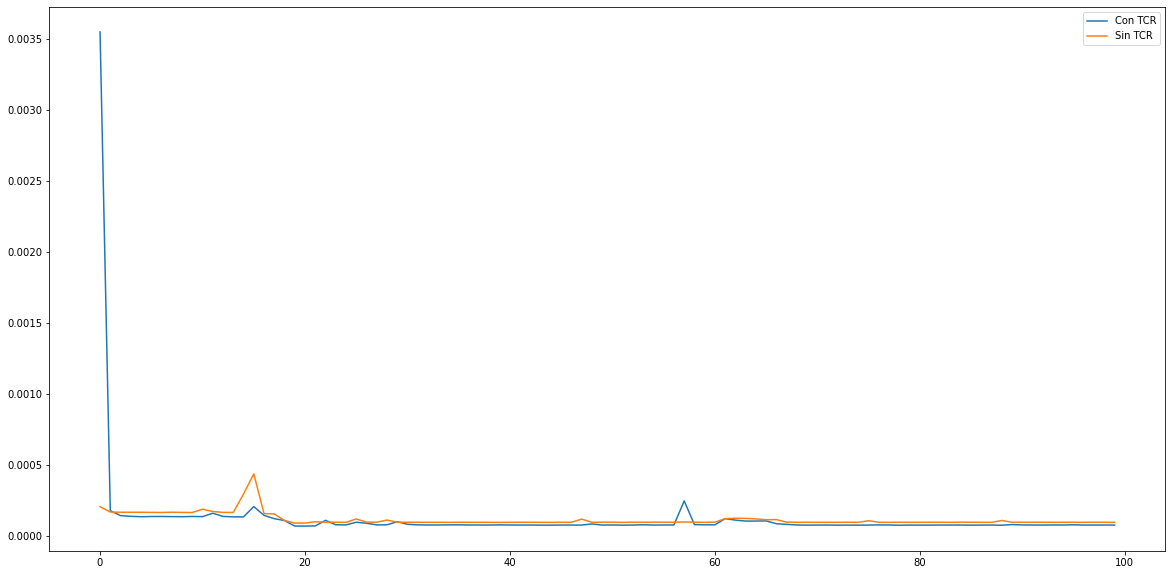

In [16]:
TCR = []
sinTCR = []

rsa = rsa_key(bits_modulo=512)

for i in listaPalabras:
    mensaje = hashlib.sha256(i.encode()).hexdigest()
    mensaje = Integer(mensaje, 16)
    inicio = timeit.default_timer()
    rsa.sign(mensaje)
    final = timeit.default_timer()
    TCR.append(final - inicio)
    
    inicio = timeit.default_timer()
    rsa.sign_slow(mensaje)
    final = timeit.default_timer()
    sinTCR.append(final-inicio)

fig = plt.figure(figsize = (20, 10))
plt.plot(range(0, len(TCR)), TCR)
plt.plot(range(0, len(sinTCR)), sinTCR)
plt.legend(['Con TCR', 'Sin TCR'])

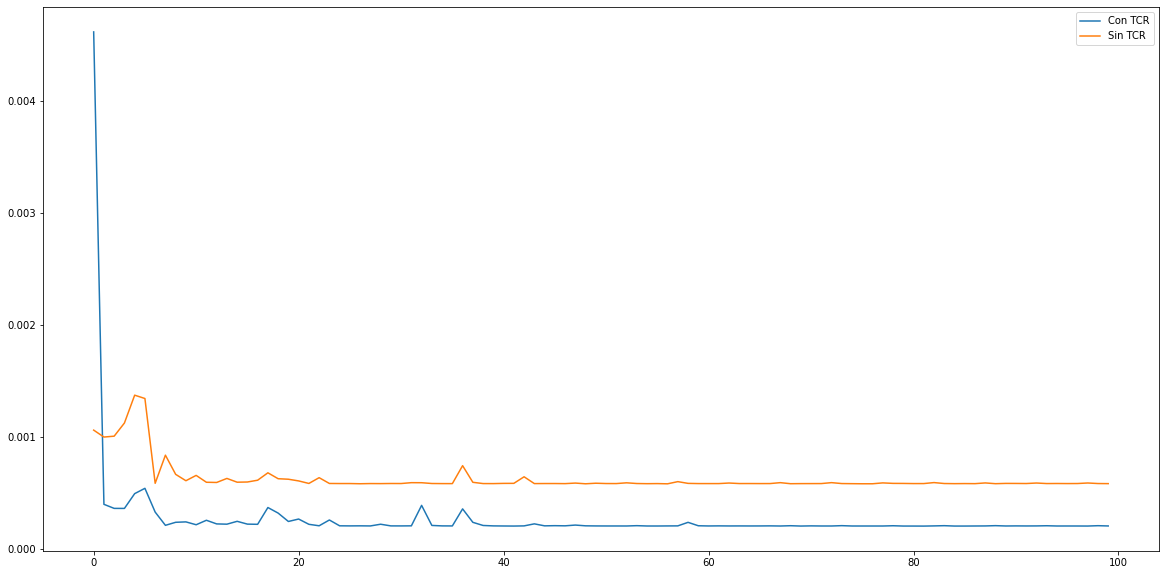

In [17]:
TCR = []
sinTCR = []

rsa = rsa_key(bits_modulo=1024)

for i in listaPalabras:
    mensaje = hashlib.sha256(i.encode()).hexdigest()
    mensaje = Integer(mensaje, 16)
    inicio = timeit.default_timer()
    rsa.sign(mensaje)
    final = timeit.default_timer()
    TCR.append(final - inicio)
    
    inicio = timeit.default_timer()
    rsa.sign_slow(mensaje)
    final = timeit.default_timer()
    sinTCR.append(final-inicio)

fig = plt.figure(figsize = (20, 10))
plt.plot(range(0, len(TCR)), TCR)
plt.plot(range(0, len(sinTCR)), sinTCR)
plt.legend(['Con TCR', 'Sin TCR'])

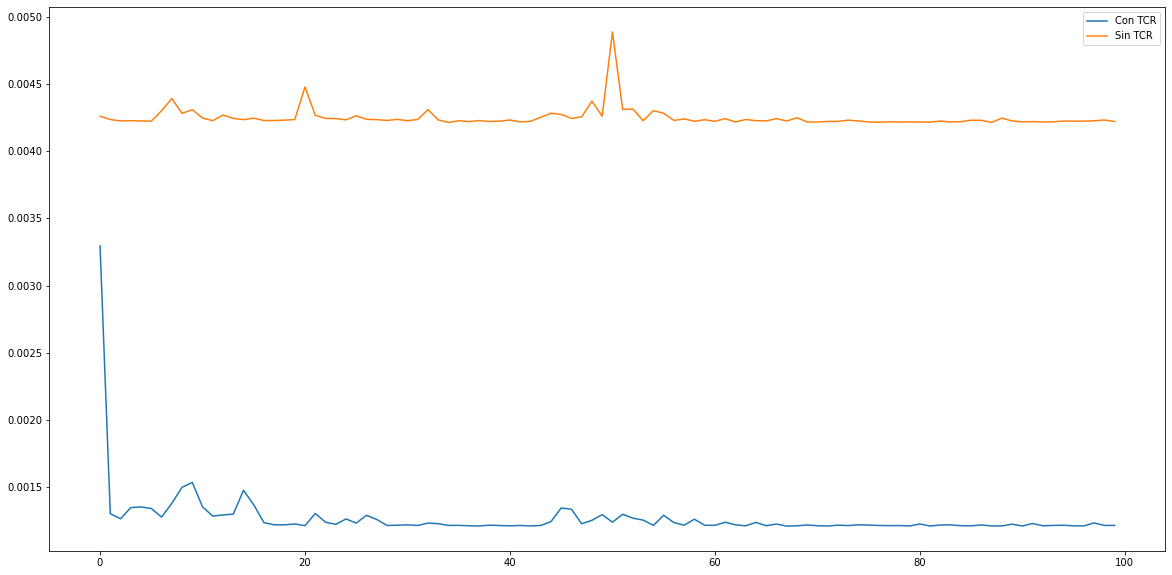

In [18]:
TCR = []
sinTCR = []

rsa = rsa_key(bits_modulo=2048)

for i in listaPalabras:
    mensaje = hashlib.sha256(i.encode()).hexdigest()
    mensaje = Integer(mensaje, 16)
    inicio = timeit.default_timer()
    rsa.sign(mensaje)
    final = timeit.default_timer()
    TCR.append(final - inicio)
    
    inicio = timeit.default_timer()
    rsa.sign_slow(mensaje)
    final = timeit.default_timer()
    sinTCR.append(final-inicio)

fig = plt.figure(figsize = (20, 10))
plt.plot(range(0, len(TCR)), TCR)
plt.plot(range(0, len(sinTCR)), sinTCR)
plt.legend(['Con TCR', 'Sin TCR'])

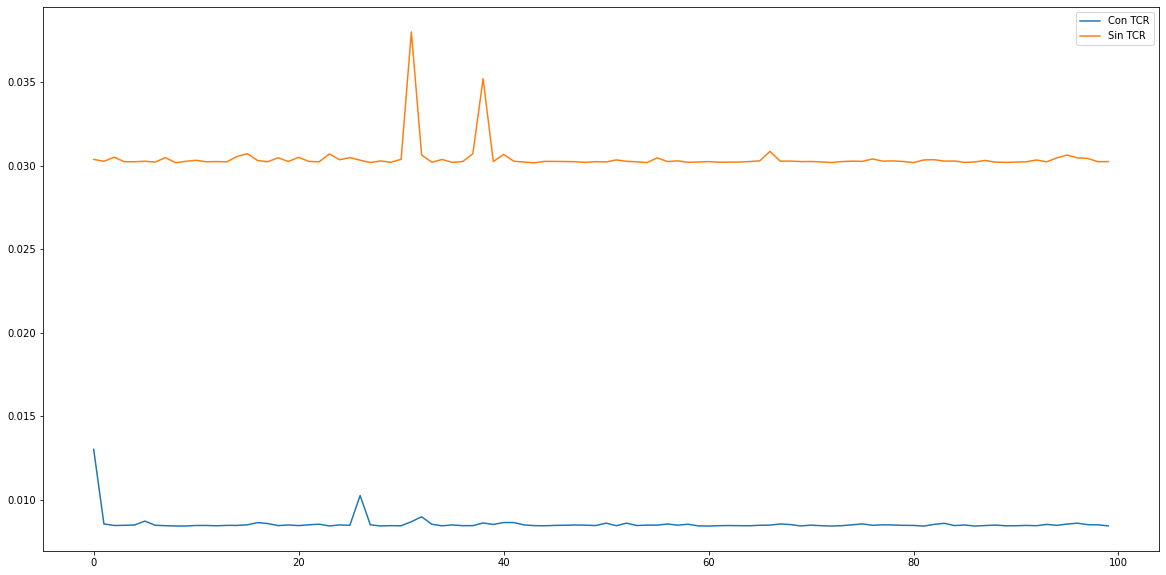

In [19]:
TCR = []
sinTCR = []

rsa = rsa_key(bits_modulo=4096)

for i in listaPalabras:
    mensaje = hashlib.sha256(i.encode()).hexdigest()
    mensaje = Integer(mensaje, 16)
    inicio = timeit.default_timer()
    rsa.sign(mensaje)
    final = timeit.default_timer()
    TCR.append(final - inicio)
    
    inicio = timeit.default_timer()
    rsa.sign_slow(mensaje)
    final = timeit.default_timer()
    sinTCR.append(final-inicio)

fig = plt.figure(figsize = (20, 10))
plt.plot(range(0, len(TCR)), TCR)
plt.plot(range(0, len(sinTCR)), sinTCR)
plt.legend(['Con TCR', 'Sin TCR'])

# Cadena válida de 100 bloques

In [20]:
inicio = timeit.default_timer()

transaccion = transaction(0, rsa_key())
bloques = block_chain(transaccion)

for i in range(1, 100):
    transaccion = transaction(i, rsa_key())
    bloques.add_block(transaccion)

final = timeit.default_timer()

print(final - inicio)

92.03190501299997


In [21]:
bloques.verify()

True

In [22]:
with open('Cadena_Pablo_Vega_bien.block', 'wb') as file:
    pickle.dump(bloques, file)

# Cadena 100 bloques válida hasta la 42

In [23]:
for index, palabra in enumerate(listaPalabras):
    rsa = rsa_key()
    mensaje = hashlib.sha256(palabra.encode()).hexdigest()
    mensaje = Integer(mensaje, 16)
    transaccion = transaction(mensaje, rsa)
    
    if index == 0:
        cadenaBloques = block_chain(transaccion)
        
    elif index == 42:
        cadenaBloques.falso(transaccion)
        
    else:
        cadenaBloques.add_block(transaccion)        

In [24]:
cadenaBloques.verify()

Hay un fallo en la iteración 42: causa mala seed


False

In [25]:
with open('Cadena_Pablo_Vega_mal.block', 'wb') as file:
    pickle.dump(cadenaBloques, file)